# 7m data (processed data explore)

![](https://www.kth.se/polopoly_fs/1.1032323.1606724850!/image/Segelfartygens%20chans%20att%20ta%20revansch%2003_liten.jpg)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [3]:
#pd.set_option('max_colwidth', -1)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from phd.visualization.maps import plot_map, plot_trips, plot_missions
import re
import geopandas
import scipy.integrate

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [4]:
ships

['M5064-02-A', 'wPCC', '7m']

In [5]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")
time_series_meta_data = catalog.load(f"{ ship }.time_series_meta_data")

[05/11/23 10:38:03] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=132698;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=105985;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/11/23 10:38:04] INFO     Kedro project phd                                                      ]8;id=410614;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=92068;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=549586;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=282848;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.time_series' (PartitionedDataSet)...         ]8;id=464538;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=867781;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=293648;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=455553;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.time_series_meta_data' (CSVDataSet)...       ]8;id=414593;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=577876;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
time_series_meta_data.sort_values(by='delta', ascending=False)

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0,date
motoring_7m_all_data,6.2832,6.2832,2.5697,37.15,37.15,59.303994,18.325294,0.2689,3.141,8.0136,3.1414,6.7439,3.1404,7.9639,3.1411,6.2145,104.0,6.1087,0.2038,0.9897,0.2972,0.2861,2.2377,1.9622,13.5755,3.1416,8.539,3.1416,7.3885,3.1416,8.434,6.7166,0.64839,2.5697,17.493956,2.530865,1.477312,26.476127,0.2689,396.798411,2757.633586,2755.997142,395.20489,2021-04-28 09:59:07.245075


In [7]:
id = "motoring_7m_all_data"
data = time_series[id]()
data['-delta'] = -data['delta']

In [8]:
data.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,mission,date,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0,-delta
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,6.2749,0.0566,0.5219,0.3838,0.2322,59.279236,18.318385,0.0087,3.0003,1.4838,2.9773,1.9999,2.7980,1.6423,2.8205,2.1337,20.0,0.0,0.0052,0.0165,0.0109,-0.0006,0.0412,-0.1080,-9.8133,2.9574,1.7029,2.8695,2.2150,2.7732,1.7491,2.2361,"Mission started at: 2021/4/29,9:22:58,command ...",2021-04-28 09:59:07.245075,-0.004053,0.5219,6.2183,0.520802,0.033840,6.2749,0.0087,0.000000,0.000000,2.755804,-0.517850,0.004053
0.199987,6.2754,0.0732,0.5305,0.5050,0.4644,59.279237,18.318385,0.0139,2.9985,1.5056,2.9758,2.0216,2.7949,1.6504,2.8181,2.1413,20.0,0.0,0.0071,0.0344,0.0056,0.0009,0.0789,-0.1363,-9.9561,2.9707,1.7646,2.8931,2.2781,2.7576,1.7491,2.2329,NaN,2021-04-28 09:59:07.445062,-0.008105,0.5305,6.2022,0.528761,0.042916,6.2754,0.0139,-0.000706,0.099428,2.855491,-0.517178,0.008105
0.400023,6.2758,0.0877,0.5344,0.4864,0.4644,59.279238,18.318385,0.0203,3.0003,1.5283,2.9764,2.0448,2.7920,1.6580,2.8152,2.1486,20.0,0.0,0.0074,0.0319,-0.0025,-0.0001,0.0691,-0.1952,-9.9039,3.0213,1.8006,2.9711,2.3241,2.7576,1.7491,2.2369,NaN,2021-04-28 09:59:07.645098,-0.008105,0.5344,6.1881,0.531986,0.050737,6.2758,0.0203,0.000710,0.187044,2.943313,-0.514660,0.008105
0.599958,6.2753,0.0901,0.5378,0.4684,0.4644,59.279239,18.318385,0.0245,3.0044,1.5488,2.9780,2.0663,2.7894,1.6649,2.8117,2.1553,20.0,0.0,0.0068,0.0107,-0.0033,-0.0012,0.0588,-0.1961,-9.8416,3.0475,1.8006,2.8104,2.3277,2.7576,1.7491,2.2369,NaN,2021-04-28 09:59:07.845033,-0.008105,0.5378,6.1852,0.535220,0.052612,6.2753,0.0245,-0.000123,0.295859,3.051870,-0.516871,0.008105
0.800069,6.2747,0.0803,0.5238,0.5080,0.4644,59.279240,18.318385,0.0246,3.0082,1.5622,2.9796,2.0806,2.7851,1.6684,2.8072,2.1584,20.0,0.0,0.0062,-0.0087,-0.0043,-0.0010,0.0571,-0.2200,-9.8506,3.0543,1.7434,2.8576,2.2733,2.7381,1.7204,2.2062,NaN,2021-04-28 09:59:08.045144,-0.008105,0.5238,6.1944,0.521737,0.046445,6.2747,0.0246,-0.005129,0.400005,3.155706,-0.523531,0.008105


In [9]:
data.select_dtypes(exclude='object').abs().max()

yaw                  6.283200
cog                  6.283200
sog                  2.569700
rudderTarget        37.150000
rudderAngle         37.150000
latitude            59.303994
longitude           18.325294
heelAngle            0.268900
awaBow               3.141000
awsBow               8.013600
twaBow               3.141400
twsBow               6.743900
awaStern             3.140400
awsStern             7.963900
twaStern             3.141100
twsStern             6.214500
thrusterTarget     104.000000
courseTarget         6.108700
pitchAngle           0.203800
GyroX                0.989700
GyroY                0.297200
GyroZ                0.286100
AccelX               2.237700
AccelY               1.962200
AccelZ              13.575500
awaBowRAW            3.141600
awsBowRAW            8.539000
twaBowRAW            3.141600
twsBowRAW            7.388500
awaSternRAW          3.141600
awsSternRAW          8.434000
twsSternRAW          6.716600
delta                0.648390
V         

<Axes: xlabel='time(us)'>

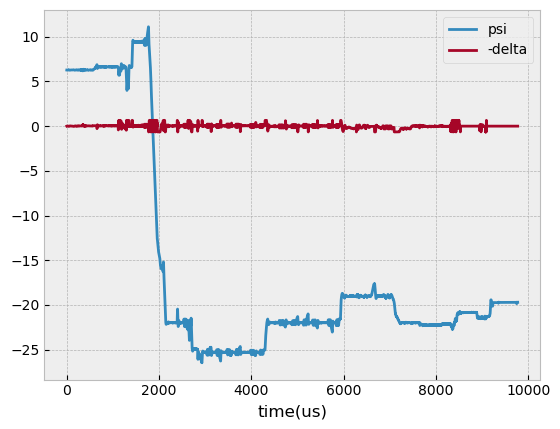

In [10]:
data.plot(y=['psi','-delta'])

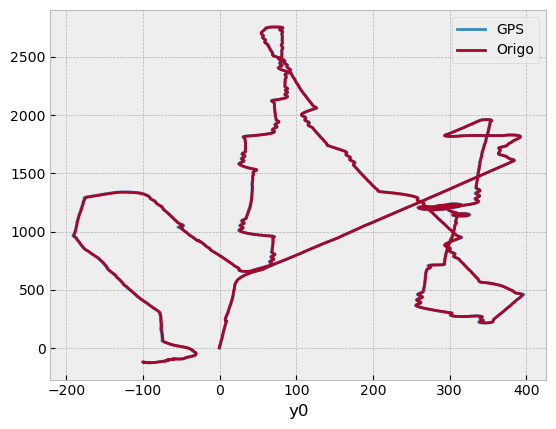

In [11]:
fig,ax=plt.subplots()
data.plot(x='y_GPS',y='x_GPS', label='GPS', ax=ax)
data.plot(x='y0',y='x0', label='Origo', ax=ax)
ax.legend()

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

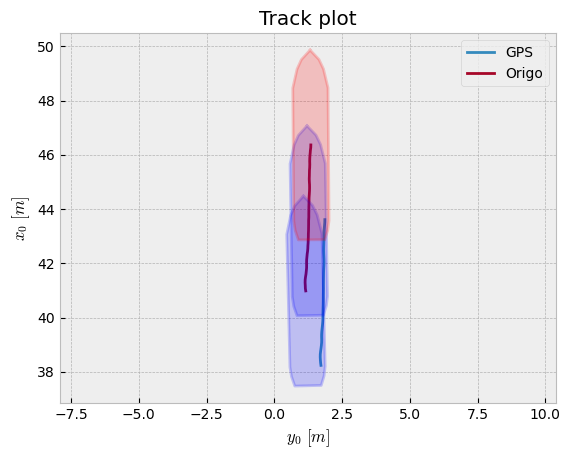

In [12]:
fig,ax=plt.subplots()
time_window=[70,80]
data.loc[time_window[0]:time_window[1]].plot(x='y_GPS',y='x_GPS', label='GPS', ax=ax)
track_plot(data, lpp=ship_data['L'], beam=ship_data['B'], time_window=time_window, label='Origo', N=3, ax=ax)


<Axes: xlabel='time(us)'>

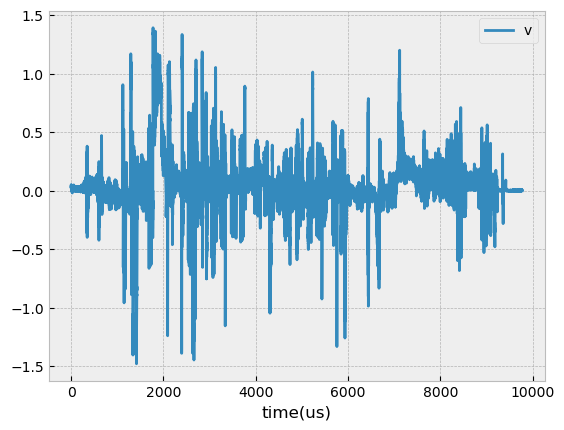

In [13]:
data.plot(y='v')

<Axes: xlabel='time(us)'>

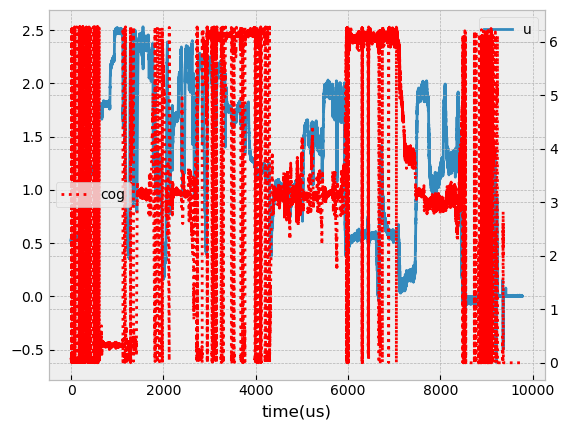

In [14]:
fig,ax=plt.subplots()
data.plot(y='u',ax=ax)
ax2 = ax.twinx()
data.plot(y='cog',style='r:',ax=ax2)

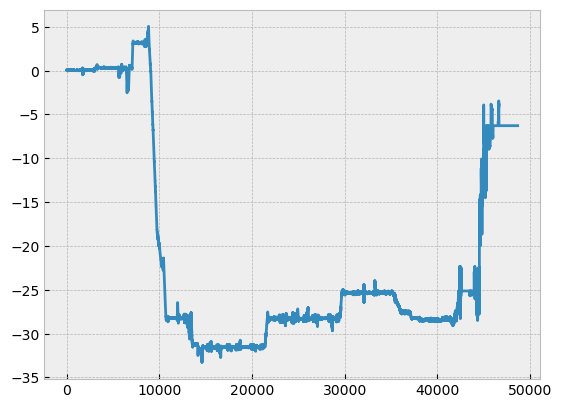

In [15]:
fig,ax=plt.subplots()
ax.plot(np.unwrap(data['cog']))

<Axes: xlabel='time(us)'>

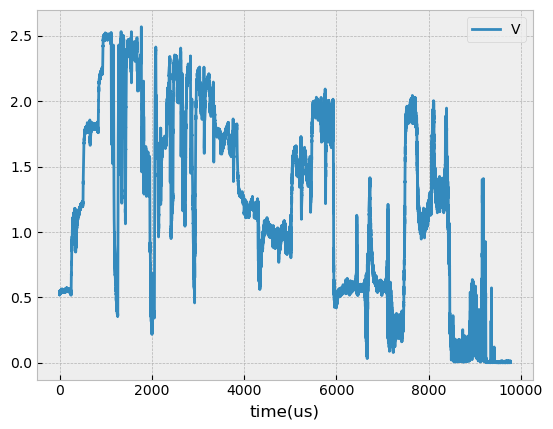

In [16]:
data.plot(y='V')

Text(0, 0.5, 'Course over ground [deg]')

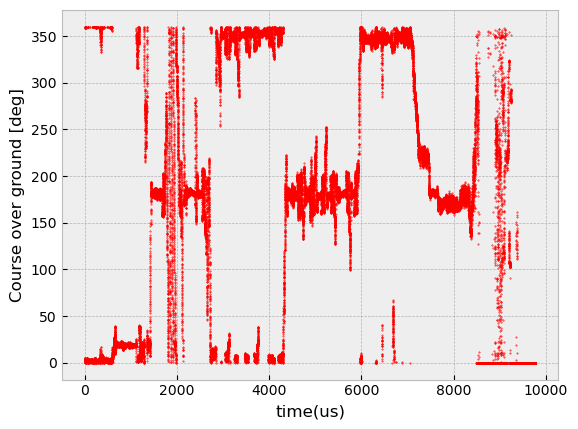

In [17]:
data['cog_deg'] = np.rad2deg(data['cog'])
fig,ax=plt.subplots()
data.plot(y='cog_deg',style='r.',ax=ax, ms=0.75)
ax.get_legend().set_visible(False);
ax.set_ylabel('Course over ground [deg]')

In [18]:
mission_rows = data['mission'].dropna()
mask = mission_rows.str.contains('command received:')
commands = mission_rows.loc[mask]
data.loc[commands.index,'trip_no'] = np.arange(0,len(commands))
data['trip_no'] = data['trip_no'].fillna(method='ffill')

In [19]:
data_ = data.copy()
data_.index= pd.to_datetime(data_['date'])
plot_missions(data_, time_step=None, width=1500,
    height=900,)

In [20]:
data['zigzag_test_id'] = np.NaN
mission_rows = data['mission'].dropna()
mask = mission_rows.str.contains("ZigZag: start")
zigzag_starts = mission_rows.loc[mask].index
data.loc[zigzag_starts,'zigzag_test_id'] = np.arange(0,len(zigzag_starts))

mask = mission_rows.str.contains("ZigZag: stop")
zigzag_stops = mission_rows.loc[mask].index
data.loc[zigzag_stops,'zigzag_test_id'] = np.arange(0,len(zigzag_stops))

for i, zigzag_start in enumerate(zigzag_starts):
    
    if i == len(zigzag_stops):
        data.loc[zigzag_start:,'zigzag_test_id'] = i
    else:      
        zigzag_stop = zigzag_stops[i]
        data.loc[zigzag_start:zigzag_stop,'zigzag_test_id'] = i
        

In [21]:
data['inbetween_zigzags_id'] = np.NaN
for i, zigzag_stop in enumerate(zigzag_stops[0:-1]):
    
    next_zigzag_start = zigzag_starts[i+1]
    zigzag_stop_i = data.index.get_loc(zigzag_stop)
    next_zigzag_start_i = data.index.get_loc(next_zigzag_start)
    start = data.index[zigzag_stop_i+1]
    end = data.index[next_zigzag_start_i-1]
        
    data.loc[start:end,'inbetween_zigzags_id'] = i + data['zigzag_test_id'].max() + 1

zigzag_start_i = data.index.get_loc(zigzag_starts[0])
end = data.index[zigzag_start_i-1]
data['inbetween_zigzags_id'].loc[data.index[0]:end] = data['inbetween_zigzags_id'].min() - 1

zigzag_stop_i = data.index.get_loc(zigzag_stops[-1])
start = data.index[zigzag_stop_i+1]
data['inbetween_zigzags_id'].loc[start:] = data['inbetween_zigzags_id'].max() + 1

<Axes: xlabel='time(us)'>

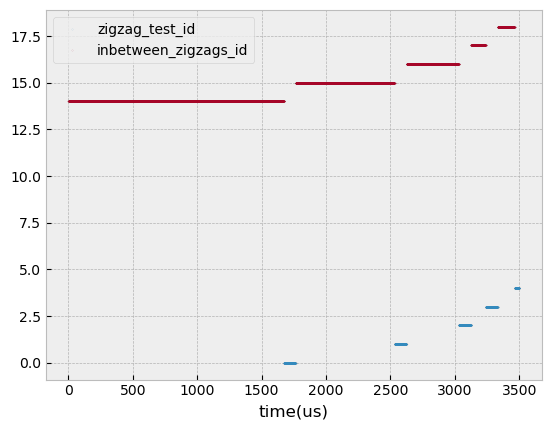

In [22]:
data.loc[0:3500].plot(y=['zigzag_test_id','inbetween_zigzags_id'], style=['.','.'], alpha=1, ms=0.1)

<Axes: xlabel='time(us)'>

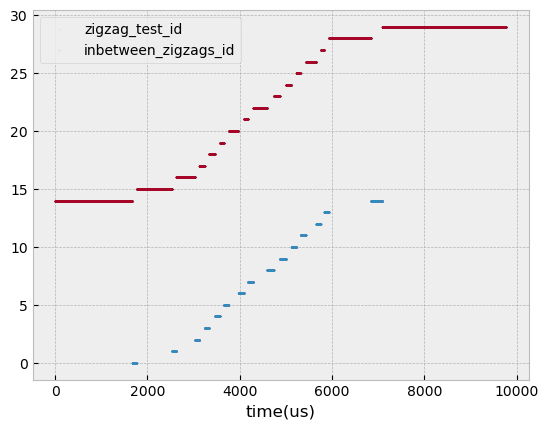

In [23]:
data.loc[-300:].plot(y=['zigzag_test_id','inbetween_zigzags_id'], style=['.','.'], alpha=1, ms=0.1)

In [24]:
assert ((data['zigzag_test_id'].notnull() & data['inbetween_zigzags_id'].isnull()) | (data['zigzag_test_id'].isnull() & data['inbetween_zigzags_id'].notnull())).all()

In [25]:
pd.set_option('display.max_rows', 500)

In [26]:
data.groupby(by='zigzag_test_id')